# Compensation Buddy

## Environment Setup

In [1]:
!pip install --upgrade kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13


In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mount Google Drive
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/Projects/CompensationBuddy'

Mounted at /content/drive


## Data Pre-Processing

In [3]:
import kagglehub
import pandas as pd
import numpy as np

try:
    # Download Official DOL Source for FY2024 (LCA)
    path = kagglehub.dataset_download("zongaobian/h1b-lca-disclosure-data-2020-2024")
    print("Files in dataset directory:")
    for file in os.listdir(path):
      print(f"- {file}")
    keep_cols = [
        'CASE_STATUS', 'EMPLOYER_NAME', 'JOB_TITLE', 'SOC_TITLE',
        'WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY', 'WORKSITE_CITY',
        'WORKSITE_STATE', 'PW_WAGE_LEVEL'
    ]
    df = pd.read_csv(f"{path}/Combined_LCA_Disclosure_Data_FY2024.csv", usecols=keep_cols, low_memory=False) # handle mixed types in govt. data with low_memory=False
    print(f"Dataset loaded. Rows: {len(df):,}")
    print(f"Columns: {df.columns.tolist()[:10]}... (Total: {len(df.columns)})")
except Exception as e:
    print(f"Dataset load failed: {e}")

# Filter out certified software roles
df = df[df['CASE_STATUS'] == 'Certified']
tech_mask = df['JOB_TITLE'].str.contains('SOFTWARE|DATA|MACHINE LEARNING|AI', case=False, na=False)
df = df[tech_mask].copy()
print(f"Found {len(df):,}-certified Tech records.")

100%|██████████| 1.27G/1.27G [00:15<00:00, 87.0MB/s]

Extracting files...


Files in dataset directory:
- Combined_LCA_Disclosure_Data_FY2020.csv
- Combined_LCA_Disclosure_Data_FY2022.csv
- Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv
- Combined_LCA_Disclosure_Data_FY2024.csv
- Combined_LCA_Disclosure_Data_FY2023.csv
- Combined_LCA_Disclosure_Data_FY2021.csv
Dataset loaded. Rows: 890,368
Columns: ['CASE_STATUS', 'JOB_TITLE', 'SOC_TITLE', 'EMPLOYER_NAME', 'WORKSITE_CITY', 'WORKSITE_STATE', 'WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY', 'PW_WAGE_LEVEL']... (Total: 9)
Found 261,468-certified Tech records.


### Data Cleaning

#### Clean the *data*

- Step 1: Since WAGE_UNIT_OF_PAY can be hours, weeks, month, week or bi-weekly, we need to convert each into annual wages
- Step 2: Filter outliers. keep only range 50000-400000
- Step 3: Normalize the data  with log1p. we want bell-shaped, symmetric data

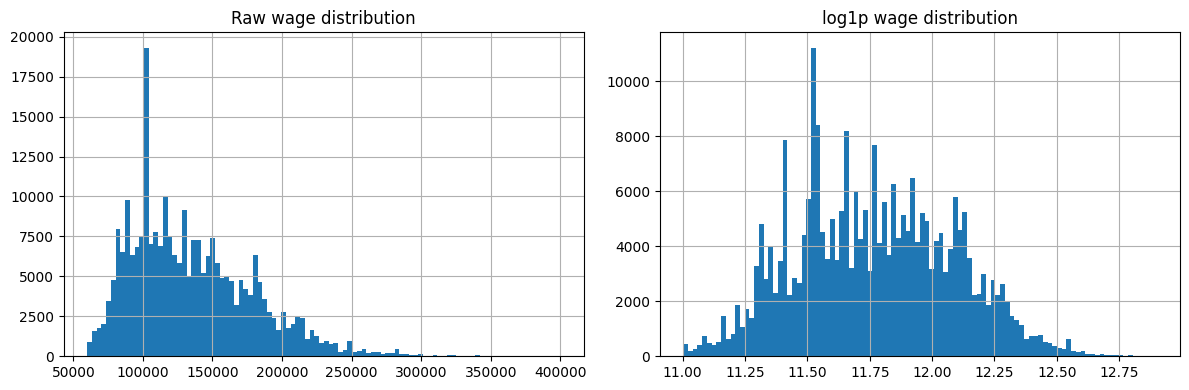

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: convert all wages to annual
multipliers = {
    'Year': 1,
    'Hour': 2080,# 40hrs * 52 weeks
    'Month': 12,
    'Week': 52,
    'Bi-Weekly': 26
}
df['annual_wage'] = df['WAGE_RATE_OF_PAY_FROM'] * df['WAGE_UNIT_OF_PAY'].map(multipliers)

# STEP 2: filter outliers
df = df[df['annual_wage'] >= 60000]
df = df[df['annual_wage'] <= 400000]

# STEP 3: normalize and plot the comparison.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['annual_wage'].hist(bins=100, ax=axes[0])
axes[0].set_title('Raw wage distribution')
# normalize with log1p
np.log1p(df['annual_wage']).hist(bins=100, ax=axes[1])
axes[1].set_title('log1p wage distribution')
plt.tight_layout()
plt.show()


#### Categorize the data

In [5]:
print(df['WORKSITE_STATE'].nunique())
print(df['PW_WAGE_LEVEL'].value_counts())
print(df['JOB_TITLE'].nunique())
print(df['EMPLOYER_NAME'].nunique())

53
PW_WAGE_LEVEL
II     117704
III     46833
IV      34806
I       33388
Name: count, dtype: int64
20877
20757


#### Categorize the JOB_TITLE field

In [6]:
def categorize_title(title):
    t = title.lower()
    if any(k in t for k in ['machine learning', 'ml engineer', ' ai ', 'artificial intelligence', 'ai engineer']):
        return 'ML/AI'
    if 'data scientist' in t or 'data science' in t:
        return 'Data Science'
    if 'data engineer' in t:
        return 'Data Engineering'
    if any(k in t for k in ['data analyst', 'business analyst', 'data analytics', 'data']):
        return 'Analytics'
    if any(k in t for k in ['database', 'db admin']):
        return 'Database'
    if any(k in t for k in ['quality', ' qa ', 'test']):
        return 'QA/Testing'
    if any(k in t for k in ['manager', 'director', 'vice president', ' vp ', 'head of']):
        return 'Management'
    if any(k in t for k in ['devops', 'cloud', 'infrastructure', 'sre', 'site reliability']):
        return 'Infrastructure'
    if any(k in t for k in ['software', 'developer', 'swe', 'development']):
        return 'Software Engineering'
    return 'Other'

df['role_category'] = df['JOB_TITLE'].apply(categorize_title)
print(df['role_category'].value_counts())
print(f"\nUncategorized 'Other' examples:")
print(df[df['role_category'] == 'Other']['JOB_TITLE'].value_counts().head(20))

role_category
Software Engineering    178470
Analytics                22332
Data Engineering         14535
Data Science             12350
Management               11778
QA/Testing                9891
ML/AI                     4594
Other                     4483
Infrastructure            1606
Name: count, dtype: int64

Uncategorized 'Other' examples:
JOB_TITLE
Airline Pilot                                    187
Physician in a Post Graduate Training Program    164
Supply Chain Analyst                             129
Regulatory Affairs Specialist                     93
Captain                                           65
Domain Consultant L3                              49
Senior Regulatory Affairs Specialist              48
Supply Chain Engineer                             48
Regulatory Affairs Associate                      46
Domain Consultant L2                              39
graduate physician trainee                        35
Domain Architect                                  30
Do

#### Categorize the 'EMPLOYER_NAME' field

seperate into two feature
  - FAANG/top company (binary flag)
  - employer type (Big Tech / Consulting / Finance / Retail / Other)

In [7]:
# define top tier companies
top_tier = {
    'google', 'microsoft', 'apple', 'meta', 'amazon',
    'netflix', 'nvidia', 'salesforce', 'adobe', 'intel'
}
def is_top_tier(name):
    n = name.lower()
    return int(any(t in n for t in top_tier))

# put companies into types
def get_industry(name):
    n = name.lower()
    if any(k in n for k in ['google', 'microsoft', 'apple', 'meta', 'amazon', 'netflix', 'nvidia', 'salesforce', 'adobe', 'intel']):
        return 'Big Tech'
    if any(k in n for k in ['cognizant', 'tata', 'infosys', 'wipro', 'mphasis', 'compunnel', 'hcl', 'accenture']):
        return 'Consulting'
    if any(k in n for k in ['jpmorgan', 'fidelity', 'ernst', 'goldman', 'morgan stanley', 'wells fargo', 'bank of america', 'deloitte']):
        return 'Finance'
    if any(k in n for k in ['optum', 'unitedhealth', 'cvs', 'mayo', 'elevance']):
        return 'Healthcare'
    return 'Other'

df['is_top_tier'] = df['EMPLOYER_NAME'].apply(is_top_tier)
df['industry'] = df['EMPLOYER_NAME'].apply(get_industry)

print(df['is_top_tier'].value_counts())
print(df['industry'].value_counts())

is_top_tier
0    205618
1     54421
Name: count, dtype: int64
industry
Other         183336
Big Tech       54421
Finance        11378
Consulting     10026
Healthcare       878
Name: count, dtype: int64


#### Infer new feature 'seniority'

In [8]:
def get_seniority(title):
    t = title.lower()
    if any(k in t for k in ['vice president', ' vp ', 'director', 'head of']):
        return 'Leadership'

    if any(k in t for k in ['manager']):
        return 'Manager'

    if any(k in t for k in ['principal', ' iv', 'architect']):
        return 'Principal'

    if any(k in t for k in ['staff']):
        return 'Staff'

    if any(k in t for k in ['senior', 'sr.', 'sr ', ' iii']):
        return 'Senior'

    if any(k in t for k in [' ii', 'mid ', 'intermediate']):
        return 'Mid'

    if any(k in t for k in ['junior', 'jr', 'associate', ' i ', 'entry']):
        return 'Entry'

    # Plain "Software Engineer" with no level indicator → Mid
    return 'Mid'

df['seniority'] = df['JOB_TITLE'].apply(get_seniority)
print(df['seniority'].value_counts())

seniority
Mid           180512
Senior         45202
Manager        11952
Principal       8920
Staff           6257
Leadership      4997
Entry           2199
Name: count, dtype: int64


#### Categorize WORKSITE_CITY

In [9]:
def get_metro_tier(city):
    c = str(city).lower().strip()

    tier1 = [
        'san francisco', 'san jose', 'sunnyvale', 'mountain view',
        'menlo park', 'palo alto', 'santa clara','seattle', 'new york', 'manhattan']

    tier2 = [
        'bellevue', 'redmond','austin','boston', 'cambridge','atlanta',
        'los angeles', 'santa monica','chicago', 'denver', 'boulder',
    ]

    if any(k in c for k in tier1):
        return 'Tier1'
    if any(k in c for k in tier2):
        return 'Tier2'
    return 'Tier3'

df['metro_tier'] = df['WORKSITE_CITY'].apply(get_metro_tier)
print(df['metro_tier'].value_counts())

metro_tier
Tier3    168603
Tier1     58643
Tier2     32793
Name: count, dtype: int64


### Data Preprocessing

- STEP 1: Drop unused columns
- STEP 2: One-Hot Encode categorical columns
- STEP 3: Spit into X (features) and Y (annual_wage)

In [10]:
import numpy as np

# Step 1: Drop unused columns
cols_to_keep = ['role_category', 'seniority', 'WORKSITE_STATE',
                'PW_WAGE_LEVEL', 'industry', 'metro_tier',
                'is_top_tier', 'annual_wage']
df_model = df[cols_to_keep].copy()

# Step 2: One-Hot Encode categorical columns
df_model = pd.get_dummies(df_model, columns=["role_category", "seniority",'WORKSITE_STATE',
                'PW_WAGE_LEVEL', 'industry', 'metro_tier' ])

# Step 3: Spit into X (features) and Y (annual_wage)
Y = df_model['annual_wage'].values.reshape(-1, 1)
X = df_model.drop(columns=['annual_wage']).values

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
np.savez('tech_salary_dataset.npz', X=X.astype(np.float32), Y=Y.astype(np.float32))

X shape: (260039, 82)
Y shape: (260039, 1)


## Model Training

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#### Utility Functions

In [12]:
# for reproducible results
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# compute MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)
@torch.no_grad()
def regression_metrics(y_true, y_pred):
    err = y_pred - y_true
    mae = err.abs().mean().item()
    rmse = (err.pow(2).mean().sqrt()).item()
    return {"mae": mae, "rmse": rmse}

# load the dataset from npz file
def load_npz(path):
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    Y = data["Y"].astype(np.float32)
    return X, Y, {}

# split data into train and validation sets
def split_indices(N, val_frac, seed):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(N) # shuffles rows
    split = int((1.0 - val_frac) * N)
    return idx[:split], idx[split:]

#### MLP Model

In [13]:
# Feedforward neural network
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, width=512, depth=4, dropout=0.0):
        super().__init__()
        layers = []
        d = in_dim

        for _ in range(depth):
            layers.append(nn.Linear(d, width))  # actual weights, transforms input to output
            layers.append(nn.LayerNorm(width))  # normalizes activations, stabilizes training
            layers.append(nn.GELU())            # activation function, adds non-linearity
            if dropout > 0:
                layers.append(nn.Dropout(dropout)) # prevent overfitting
            d = width # update input for next layer

        layers.append(nn.Linear(d, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

#### Scalers

Standardizes features to zero mean and unit variance

In [14]:
from dataclasses import dataclass

@dataclass
class Scalers:
    x_mean: np.ndarray
    x_std: np.ndarray
    y_mean: np.ndarray
    y_std: np.ndarray

def fit_scalers(X, Y):
    x_mean = X.mean(axis=0, keepdims=True)
    x_std = X.std(axis=0, keepdims=True) + 1e-8
    y_mean = Y.mean(axis=0, keepdims=True)
    y_std = Y.std(axis=0, keepdims=True) + 1e-8
    return Scalers(x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std)

def apply_x_scaler(X, s):
    return (X - s.x_mean) / s.x_std

def apply_y_scaler(Y, s):
    return (Y - s.y_mean) / s.y_std

def invert_y_scaler(Yn, s):
    return Yn * s.y_std + s.y_mean

### Training Function

In [28]:
train_losses = []
val_losses = []
val_maes = []

def train(X, Y, out_dir, seed=0, val_frac=0.1, width=512, depth=4,
          dropout=0.0, epochs=40, batch_size=1024, lr=3e-4,
          weight_decay=1e-2, amp=True, device=None):

    # ------------- Training Setup ------------#

    import os, json, time
    os.makedirs(out_dir, exist_ok=True)
    set_seed(seed)

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device) # auto-detect GPU vs CPU

    N, in_dim = X.shape
    out_dim = Y.shape[1]
    print(f"Dataset: N={N}, in_dim={in_dim}, out_dim={out_dim}")

    # Split
    tr_idx, va_idx = split_indices(N, val_frac, seed)
    Xtr, Xva = X[tr_idx], X[va_idx]
    Ytr, Yva = Y[tr_idx], Y[va_idx]

    # Log1p transform on Y before scaling
    Ytr_log = np.log1p(Ytr)
    Yva_log = np.log1p(Yva)

    # Fit scalers on train only
    scalers = fit_scalers(Xtr, Ytr_log)
    # Save scalers
    np.savez(
        os.path.join(out_dir, 'scalers.npz'),
        x_mean=scalers.x_mean.astype(np.float32),
        x_std=scalers.x_std.astype(np.float32),
        y_mean=scalers.y_mean.astype(np.float32),
        y_std=scalers.y_std.astype(np.float32),
    )
    Xtr_n = apply_x_scaler(Xtr, scalers).astype(np.float32)
    Xva_n = apply_x_scaler(Xva, scalers).astype(np.float32)
    Ytr_n = apply_y_scaler(Ytr_log, scalers).astype(np.float32)
    Yva_n = apply_y_scaler(Yva_log, scalers).astype(np.float32)

    # Build DataLoaders
    tr_ds = TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(Ytr_n))
    va_ds = TensorDataset(torch.from_numpy(Xva_n), torch.from_numpy(Yva_n))
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=0) # shuffle to prevent model memorization
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    # Model, optimizer, loss
    model = MLP(in_dim=in_dim, out_dim=out_dim, width=width, depth=depth, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer with weight decay
    loss_fn = nn.MSELoss()

    use_amp = (device == "cuda") and amp
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    best_val = float("inf") # tracks the best validation loss
    best_path = os.path.join(out_dir, "best.pt")

    # ------------- Training Loop ------------#
    for ep in range(1, epochs + 1):
        t0 = time.time()

        # --- Training phase
        model.train()
        tr_loss = 0.0

        for xb, yb in tr_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True) # clears gradients from previous batch

            with torch.cuda.amp.autocast(enabled=use_amp):
                pred = model(xb)
                loss = loss_fn(pred, yb)

            scaler.scale(loss).backward() # computes gradients via backpropagation
            scaler.step(opt) # updates model weights
            scaler.update()

            tr_loss += loss.item() * xb.size(0) # weighted average loss across batches of different size

        tr_loss /= len(tr_loader.dataset)

        # --- Validation phase
        model.eval()
        va_loss = 0.0
        y_true_list, y_pred_list = [], []

        with torch.no_grad():
            for xb, yb in va_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                with torch.cuda.amp.autocast(enabled=use_amp):
                    pred = model(xb)
                    loss = loss_fn(pred, yb)

                va_loss += loss.item() * xb.size(0)

                # Convert back to original dollar scale
                pred_log = invert_y_scaler(pred.cpu().numpy(), scalers)
                true_log = invert_y_scaler(yb.cpu().numpy(), scalers)
                y_pred_list.append(np.expm1(pred_log))
                y_true_list.append(np.expm1(true_log))

        va_loss /= len(va_loader.dataset)

        y_true = torch.from_numpy(np.concatenate(y_true_list, axis=0))
        y_pred = torch.from_numpy(np.concatenate(y_pred_list, axis=0))
        mets = regression_metrics(y_true, y_pred)

        dt = time.time() - t0
        print(f"epoch {ep:03d} | train_mse={tr_loss:.6f} | val_mse={va_loss:.6f} | "
              f"val_mae={mets['mae']:.2f} | val_rmse={mets['rmse']:.2f} | {dt:.1f}s")

        if va_loss < best_val:
            best_val = va_loss
            torch.save({"model_state": model.state_dict(), "cfg": {
                "in_dim": in_dim, "out_dim": out_dim, "width": width,
                "depth": depth, "dropout": dropout
            }}, best_path)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        val_maes.append(mets['mae'])

    print(f"\nTraining complete. Best val mse: {best_val:.6f}")
    print(f"Best checkpoint saved to: {best_path}")

### Prediction Function

In [16]:
def load_scalers(path):
  # reloads the mean/std values from training
    d = np.load(path)
    return Scalers(
        x_mean=d["x_mean"].astype(np.float32),
        x_std=d["x_std"].astype(np.float32),
        y_mean=d["y_mean"].astype(np.float32),
        y_std=d["y_std"].astype(np.float32),
    )

@torch.no_grad()
def predict(model_path, scalers_path, X, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    ckpt = torch.load(model_path, map_location="cpu")
    cfg = ckpt["cfg"]
    model = MLP(cfg["in_dim"], cfg["out_dim"], width=cfg["width"],
                depth=cfg["depth"], dropout=cfg["dropout"])
    model.load_state_dict(ckpt["model_state"]) # restores the trained weights into the model
    model.to(device).eval()

    scalers = load_scalers(scalers_path)

    Xn = apply_x_scaler(X.astype(np.float32), scalers)
    xb = torch.from_numpy(Xn).to(device)

    pred_n = model(xb).detach().cpu().numpy()
    pred_log = invert_y_scaler(pred_n, scalers)
    pred_y = np.expm1(pred_log).astype(np.float32)
    return pred_y

### Train the model

In [29]:
import os

X, Y, _ = load_npz('tech_salary_dataset.npz')

train(
    X=X,
    Y=Y,
    out_dir='compensation_buddy',
    seed=0,
    val_frac=0.1,
    width=512,
    depth=4,
    dropout=0.0,
    epochs=40,
    batch_size=1024,
    lr=3e-4,
    weight_decay=1e-2,
    amp=True
)

Device: cuda
Dataset: N=260039, in_dim=82, out_dim=1


/tmp/ipython-input-1217238736.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-1217238736.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-1217238736.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


epoch 001 | train_mse=0.279482 | val_mse=0.250127 | val_mae=15749.37 | val_rmse=23310.58 | 2.6s
epoch 002 | train_mse=0.241905 | val_mse=0.244324 | val_mae=15557.50 | val_rmse=23134.87 | 2.7s
epoch 003 | train_mse=0.236560 | val_mse=0.241663 | val_mae=15426.68 | val_rmse=22856.82 | 2.6s
epoch 004 | train_mse=0.233421 | val_mse=0.239095 | val_mae=15239.14 | val_rmse=22809.19 | 3.3s
epoch 005 | train_mse=0.230747 | val_mse=0.239901 | val_mae=15364.60 | val_rmse=22841.07 | 3.1s
epoch 006 | train_mse=0.228897 | val_mse=0.242055 | val_mae=15373.92 | val_rmse=23024.80 | 2.6s
epoch 007 | train_mse=0.227946 | val_mse=0.235402 | val_mae=15206.29 | val_rmse=22597.65 | 2.6s
epoch 008 | train_mse=0.226188 | val_mse=0.241389 | val_mae=15552.34 | val_rmse=22623.85 | 2.7s
epoch 009 | train_mse=0.225192 | val_mse=0.233539 | val_mae=15085.03 | val_rmse=22510.39 | 3.8s
epoch 010 | train_mse=0.224391 | val_mse=0.237336 | val_mae=15219.12 | val_rmse=22811.91 | 2.6s
epoch 011 | train_mse=0.223609 | val_mse

In [23]:
train_losses

[0.21542705137981474]

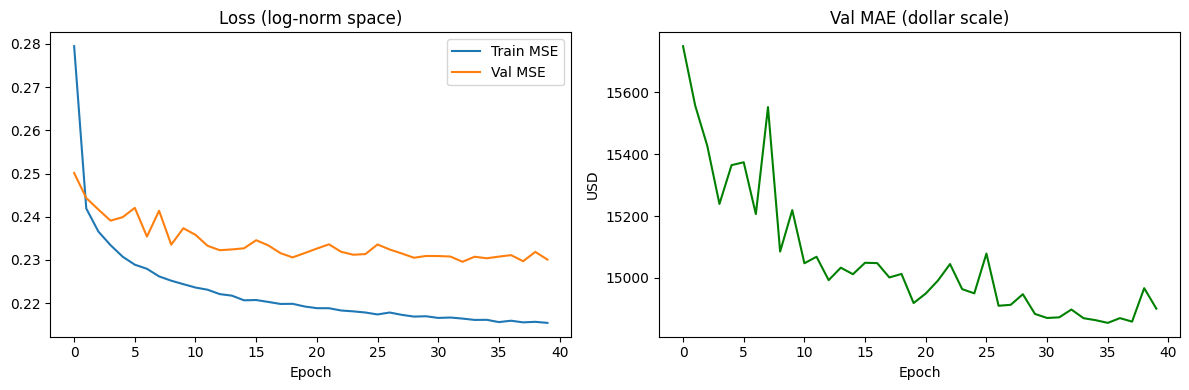

In [30]:
# plot the training curves

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train MSE')
axes[0].plot(val_losses, label='Val MSE')
axes[0].set_title('Loss (log-norm space)')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(val_maes, color='green')
axes[1].set_title('Val MAE (dollar scale)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('USD')

plt.tight_layout()
plt.show()

## Prediction

In [32]:
# Load the best checkpoint and predict on validation set
X, Y, _ = load_npz('tech_salary_dataset.npz')
tr_idx, va_idx = split_indices(len(X), 0.1, seed=0)

Xva = X[va_idx]
Yva = Y[va_idx]

pred = predict('compensation_buddy/best.pt', 'compensation_buddy/scalers.npz', Xva)

y_true = Yva.flatten()
y_pred = pred.flatten()

print(f"Samples evaluated: {len(y_true)}")
print(f"MAE:  ${np.mean(np.abs(y_pred - y_true)):,.0f}")
print(f"RMSE: ${np.sqrt(np.mean((y_pred - y_true)**2)):,.0f}")

Samples evaluated: 26004
MAE:  $14,897
RMSE: $22,352


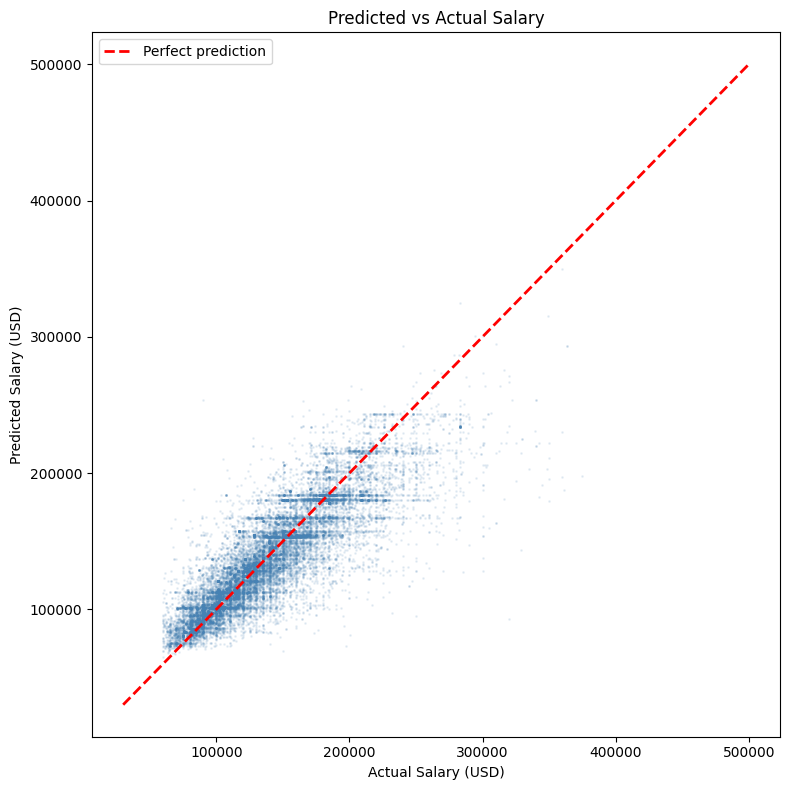

In [33]:
# predicted vs actual

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_true, y_pred, alpha=0.1, s=1, color='steelblue')

# Perfect prediction line
ax.plot([30000, 500000], [30000, 500000], 'r--', linewidth=2, label='Perfect prediction')

ax.set_xlabel('Actual Salary (USD)')
ax.set_ylabel('Predicted Salary (USD)')
ax.set_title('Predicted vs Actual Salary')
ax.legend()

plt.tight_layout()
plt.savefig('pred_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipython-input-2518209388.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('bucket')['error'].mean()


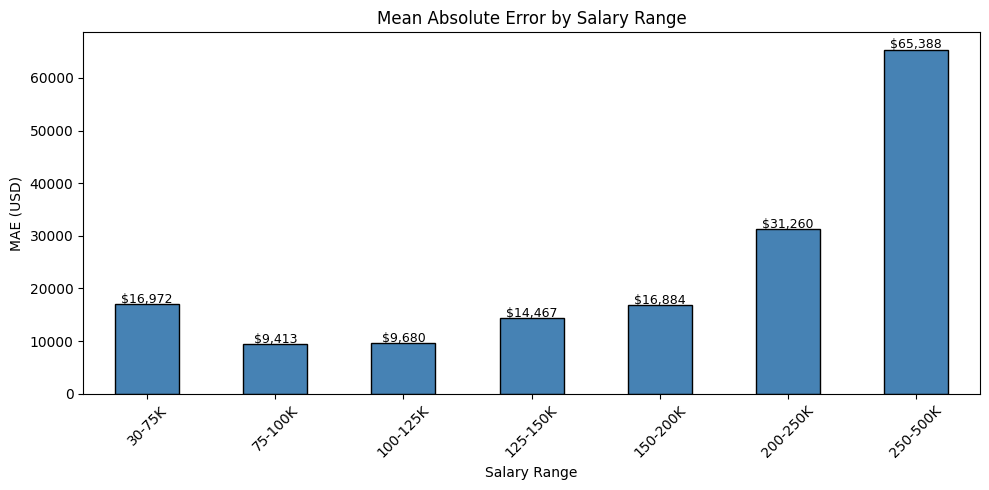

In [36]:

# Create salary Range
bins = [30000, 75000, 100000, 125000, 150000, 200000, 250000, 500000]
labels = ['30-75K', '75-100K', '100-125K', '125-150K', '150-200K', '200-250K', '250-500K']

bucket = pd.cut(y_true, bins=bins, labels=labels)
errors = np.abs(y_pred - y_true)

# Compute MAE per bucket
mae_by_bucket = pd.DataFrame({
    'bucket': bucket,
    'error': errors
}).groupby('bucket')['error'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
mae_by_bucket.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Mean Absolute Error by Salary Range')
ax.set_xlabel('Salary Range')
ax.set_ylabel('MAE (USD)')
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of bars
for i, v in enumerate(mae_by_bucket):
    ax.text(i, v + 200, f'${v:,.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('error_by_bucket.png', dpi=150, bbox_inches='tight')
plt.show()

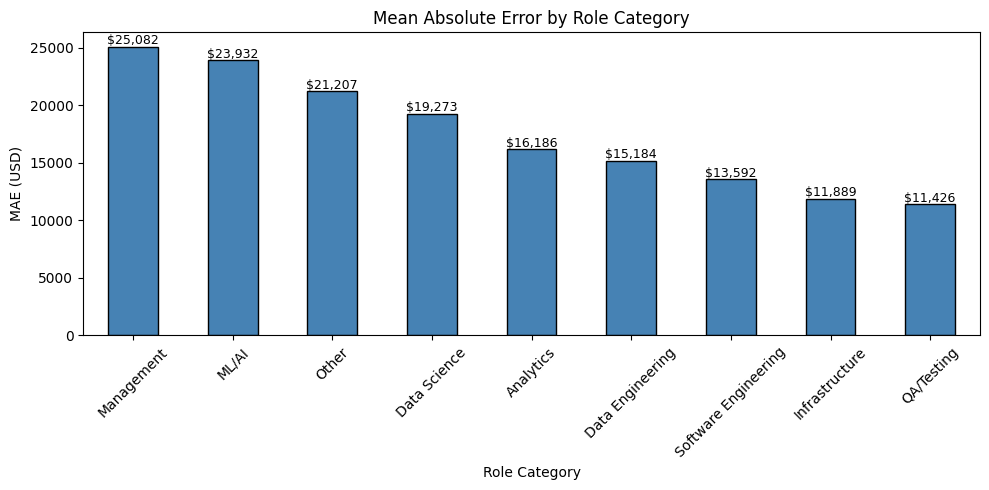

In [37]:
# Construct role categories for validation set
df_val = df.iloc[va_idx].copy()

mae_by_role = pd.DataFrame({
    'role': df_val['role_category'].values,
    'error': errors
}).groupby('role')['error'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
mae_by_role.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Mean Absolute Error by Role Category')
ax.set_xlabel('Role Category')
ax.set_ylabel('MAE (USD)')
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(mae_by_role):
    ax.text(i, v + 200, f'${v:,.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('error_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

# Streamlit App

In [38]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.3 MB/s eta 0:00:00
